## Analysing model training

In [85]:
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import config_util
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(config_util)
reload(data_util)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder


In [86]:
import torch
import numpy as np
import sympy as sp
from util import prods_to_eq, logits_to_prefix, logits_to_prods
from config_util import dict_to_config, load_config
from data_util import data2input, load_dataset, calc_priors_and_means, create_dataloader, load_wandb_model
from debug_util import plot_onehot
import wandb
from model import GrammarVAE
import yaml
from matplotlib import pyplot as plt
torch.manual_seed(41)

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240817_2')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)
value_transform = lambda x: torch.arcsinh(x)*0.1
val_transformed = value_transform(torch.tensor(val)).detach().numpy()

# Load model
vae_model, cfg_dict, cfg = load_wandb_model(run='24ryl3yz')

/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Using updated value decoder 2.0!


In [3]:
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total number of parameters in vae_model: {total_params}")
trainable_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in vae_model: {trainable_params}")
encoder_params = sum(p.numel() for p in vae_model.encoder.parameters())
print(f"Number of parameters in encoder: {encoder_params}")
decoder_params = sum(p.numel() for p in vae_model.decoder.parameters())
print(f"Number of parameters in decoder: {decoder_params}")
value_decoder_params = sum(p.numel() for p in vae_model.value_decoder.parameters())
print(f"Number of parameters in value_decoder: {value_decoder_params}")


Total number of parameters in vae_model: 700046
Total number of trainable parameters in vae_model: 700046
Number of parameters in encoder: 93024
Number of parameters in decoder: 46282
Number of parameters in value_decoder: 560740


In [4]:
from data_util import create_dataloader

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', cfg, value_transform=lambda x: torch.arcsinh(x)*0.1)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."

## Syntax parsing

In [83]:
from importlib import reload
import grammar
import parsing
reload(util)
reload(grammar)
reload(parsing)
from parsing import logits_to_prods, eval_from_logits
import sympy as sp

i = 5
all_evaluated = []
for i in range(100):
    x = data2input(data_syntax[i, ...])
    logits, values_pred = vae_model.forward(x)
    evaluated = eval_from_logits(logits, val_x.squeeze())
    all_evaluated.append(evaluated)
# plt.plot(val_x, evaluated)
# plt.show()



## Syntax decoding accuracy

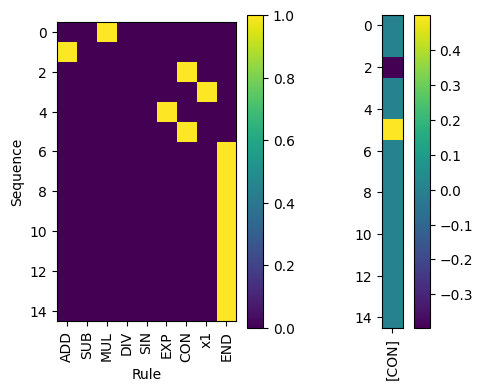

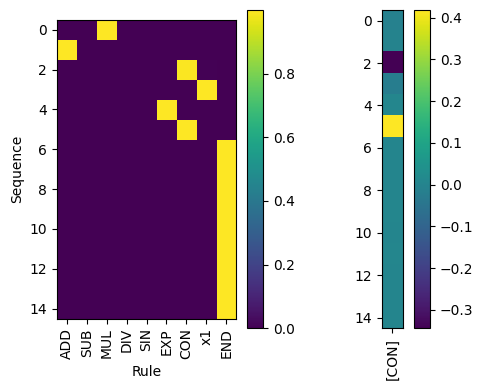

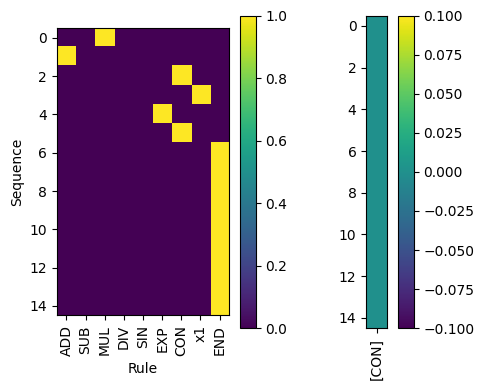

In [213]:
i = 10
x = data2input(data_syntax[i, ...])
# x = all_x[i, ...].unsqueeze(0)

logits, values_pred = vae_model.forward(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))


# Create a matrix where the argmax column is 1 and everything else is 0 for each row
logits_numpy = logits.squeeze(0).detach().numpy().copy()
argmax_matrix = np.zeros_like(logits_numpy)
argmax_indices = np.argmax(logits_numpy, axis=1)
argmax_matrix[np.arange(logits_numpy.shape[0]), argmax_indices] = 1

# Plot the argmax matrix
plot_onehot(argmax_matrix, syntax_cats, apply_softmax=False, figsize=(5, 4))


## Value decoding accuracy

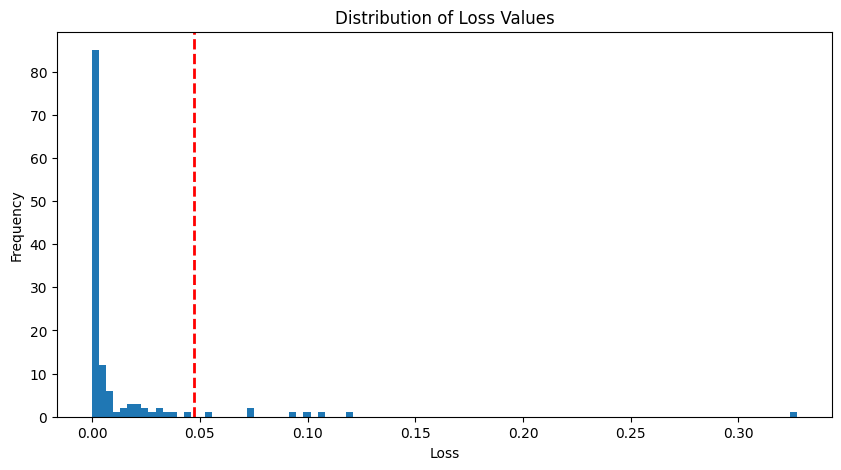

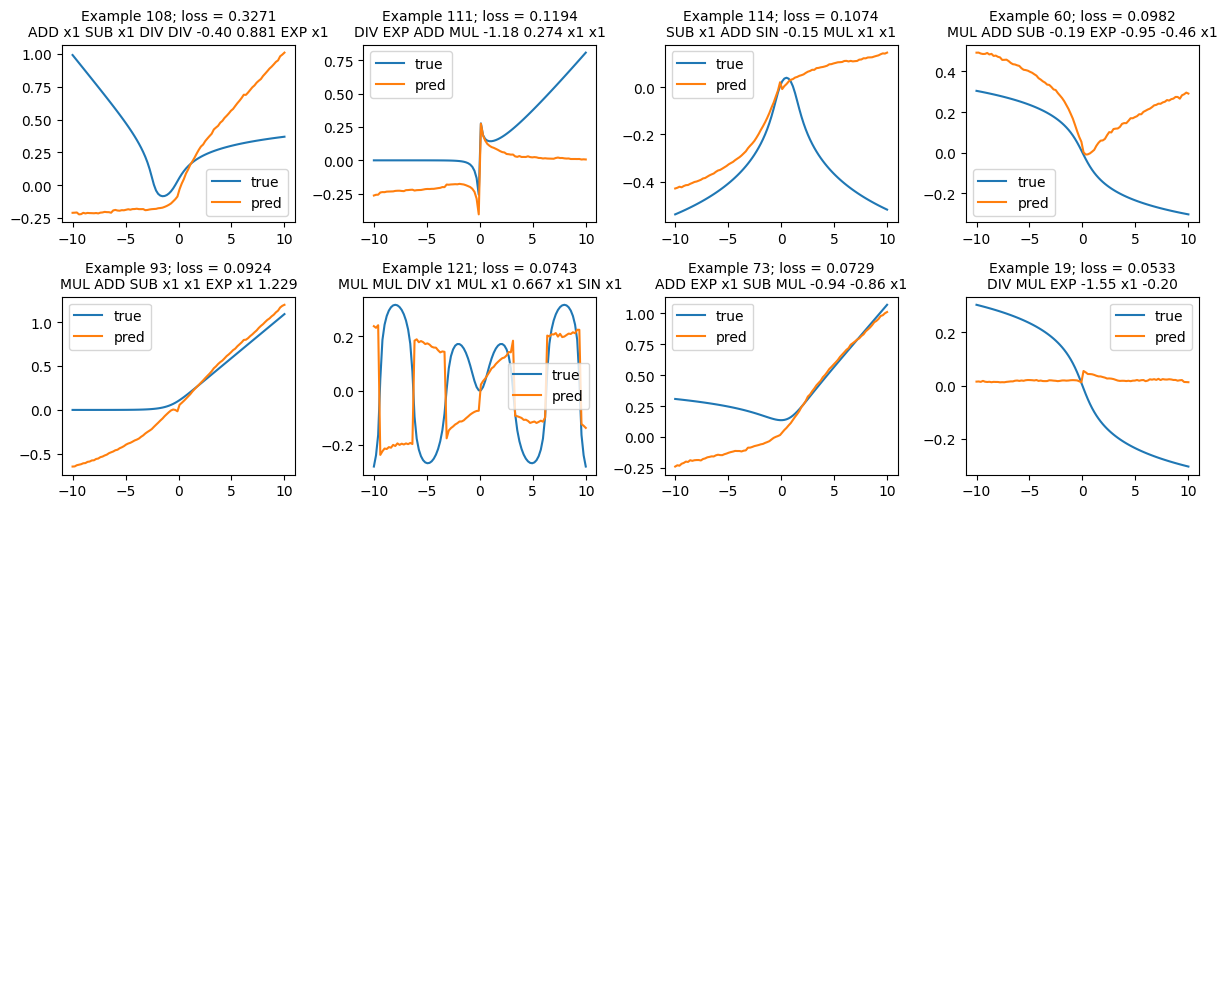

In [20]:
from grammar import GCFG

i = 2
N = 128
data_loader = test_loader
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]
values_true = data_loader.dataset.dataset[data_loader.dataset.indices][3][i:i+N, ...]

# Calculate predictions
_, values_pred = vae_model.forward(x)

# Calculate loss for each example
mse = torch.nn.MSELoss(reduction='none')
loss = mse(values_pred, values_true).mean(axis=1)

# Calculate mean and standard deviation of loss
loss_mean = loss.mean()
loss_std = loss.std()

# Set threshold (e.g., 1 standard deviation above mean)
threshold = loss_mean + 1 * loss_std

# Sort indices by loss in descending order
sorted_indices = torch.argsort(loss, descending=True)

# Plot histogram of loss values
plt.figure(figsize=(10, 5))
plt.hist(loss.detach().numpy(), bins=100)
plt.axvline(threshold.detach().numpy(), color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Loss Values')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

# Plot function values for highest-loss examples above threshold
num_plots = 16  # Limit to 16 plots
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 2.5 * num_rows), squeeze=False)
fig.tight_layout(pad=5.0)

plot_count = 0
for i in range(len(sorted_indices)):
    if plot_count >= num_plots:
        break
    
    idx = sorted_indices[i]
    if loss[idx] < threshold:
        continue
    
    row = plot_count // num_cols
    col = plot_count % num_cols
    
    y_true = values_true[idx, ...]
    y_pred = values_pred[idx, ...]
    
    # Plot function values
    axs[row, col].plot(val_x, y_true.squeeze().detach().numpy(), label='true')
    axs[row, col].plot(val_x, y_pred.squeeze().detach().numpy(), label='pred')
    axs[row, col].legend()
    prods = logits_to_prods(x[idx, ...].squeeze(0).T, GCFG, sample=False)
    prefix = [s[:min(5, len(s))] for s in prods_to_eq(prods)]
    eq_str = ' '.join(prefix)
    axs[row, col].set_title(f'Example {idx.item()}; loss = {loss[idx].item():.4f}\n{eq_str}', fontsize=10)
    
    plot_count += 1

# Hide any unused subplots
for i in range(plot_count, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()